<a href="https://colab.research.google.com/github/ETorresSacha/Analisis-de-datos/blob/main/analisis_datos_reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
from google.colab import files
import seaborn as sns
from sklearn import  preprocessing

In [ ]:

uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['TEMP2.xlsx']))

KeyError: 'TEMP2.xlsx'

In [ ]:
df.sort_values(by=['equipment','location','start_detention'],inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

,reason,equipment,location,start_detention,end_detention,pay_number,id,comment,Minutos
0,MANTENCION NO PROGRAMADA,C301,8A,2021-10-04 21:53:48,2021-10-04 23:00:00,NaN,2674096,Alarma freno traba y servicio aplicado,67
1,MANTENCION NO PROGRAMADA,C301,8A,2021-10-04 23:00:00,2021-10-05 11:00:00,NaN,0,NaN,720
2,MANTENCION NO PROGRAMADA,C301,8A,2021-10-05 11:00:00,2021-10-05 23:00:00,NaN,0,NaN,720
3,MANTENCION NO PROGRAMADA,C301,8A,2021-10-05 23:00:00,2021-10-06 08:48:37,NaN,0,NaN,588
4,MANTENCION NO PROGRAMADA,C301,AUX001,2020-06-24 12:14:16,2020-06-24 13:22:06,NaN,2091922,Filtros congelados,68


In [ ]:
# Exportamos a excel los datos de mnp_caex
df.to_excel('mnp_caex.xlsx', index=False)


In [ ]:
# Descargar el archivo
files.download('mnp_caex.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANÁLISIS DE DATOS DEL RUL
### TABLA TELEMETRÍA Y ALERTAS

In [4]:
uploaded = files.upload()

Saving CAEX_RUL2.xlsx to CAEX_RUL2.xlsx


In [ ]:
# para borrar los datos que se sucbió
os.remove("CAEX_RUL4.xlsx")

In [5]:
data = pd.read_excel(io.BytesIO(uploaded['CAEX_RUL2.xlsx']))

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


###  Paso 1 – Exploración inicial de la data (EDA básico).

In [ ]:
# Vista rápida de la estructura
print("Dimensiones del dataset:", data.shape)
print("\nTipos de datos:")
print(data.dtypes)

Dimensiones del dataset: (7524, 58)

Tipos de datos:
equipment                                          object
Ambient_Temp_Ave                                  float64
Ambient_Temp_Max                                  float64
Ambient_Temp_Min                                  float64
Atmos_Pres_Ave                                    float64
Blow_by_Press_Max                                 float64
Boost_LB_Press_Max                                float64
Boost_RB_Press_Max                                float64
BRAKE_ENERGY                                      float64
Brake_Oil_Temp_LF_Ave                             float64
Brake_Oil_Temp_LF_Max                             float64
Brake_Oil_Temp_LR_Ave                             float64
Brake_Oil_Temp_LR_Max                             float64
Brake_Oil_Temp_RF_Ave                             float64
Brake_Oil_Temp_RF_Max                             float64
Brake_Oil_Temp_RR_Ave                             float64
Brake_Oil_Temp_RR_M

In [ ]:
# Primeras filas
print("\nPrimeras 5 filas:")
display(data.head())


Primeras 5 filas:


,equipment,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,Boost_RB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
0,C301,14.0,25.0,5.0,58.0,2.0,268.0,258.0,1.0,40.0,...,20290.0,6580.0,20230.0,21914.0,2953.0,2963.0,2021-01-13 18:23:40,2021-01-13 20:11:01,38538,2
1,C301,14.0,35.0,6.0,58.0,2.0,270.0,259.0,3.0,51.0,...,20750.0,6650.0,20440.0,21914.0,2779.0,2695.0,2021-01-18 23:30:42,2021-01-19 08:05:10,38598,9
2,C301,9.0,24.0,0.0,58.0,1.0,266.0,266.0,4.0,53.0,...,21240.0,6630.0,20890.0,20062.0,2487.0,2502.0,2021-04-30 21:49:45,2021-05-01 08:45:43,39378,11
3,C301,9.0,29.0,0.0,58.0,1.0,266.0,266.0,5.0,60.0,...,20120.0,6970.0,21680.0,19977.0,2663.0,2665.0,2021-05-06 21:52:31,2021-05-07 06:55:36,39478,9
4,C301,9.0,22.0,1.0,58.0,1.0,268.0,271.0,7.0,51.0,...,20530.0,6670.0,20270.0,20062.0,2446.0,2413.0,2021-05-14 08:21:45,2021-05-15 09:36:48,39618,25


In [ ]:
# Resumen estadístico de todas las columnas numéricas
print("\nResumen estadístico:")
display(data.describe())


Resumen estadístico:


,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,Boost_RB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,Brake_Oil_Temp_LF_Max,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
count,7521.000000,7475.000000,7475.000000,7521.000000,6780.000000,7521.000000,6772.000000,7521.000000,7521.000000,7521.000000,...,7044.000000,7521.000000,7044.000000,7521.000000,7521.000000,7521.000000,7524,7524,7524.000000,7524.000000
mean,11.559101,28.018595,-3.872107,58.665337,1.519764,265.789124,262.372120,4.259008,54.834596,66.692993,...,20825.139125,7049.375083,20858.344691,21682.801090,2458.836325,2458.842308,2021-08-13 06:49:31.575491584,2021-08-14 21:00:43.675704576,35753.889421,38.223285
min,-133.000000,-62.000000,-272.000000,31.000000,0.000000,158.000000,157.000000,0.000000,-114.000000,21.000000,...,4690.000000,0.000000,4780.000000,0.000000,0.000000,0.000000,2019-08-07 07:22:27,2020-01-05 11:02:53,10529.000000,0.000000
25%,8.000000,23.000000,0.000000,58.000000,1.000000,260.000000,256.000000,0.000000,49.000000,62.000000,...,20200.000000,7040.000000,20140.000000,20861.000000,2401.000000,2394.000000,2021-04-19 06:14:33.500000,2021-04-19 17:26:36.750000128,27294.000000,3.000000
50%,12.000000,28.000000,2.000000,58.000000,1.000000,266.000000,261.000000,2.000000,56.000000,67.000000,...,20680.000000,7470.000000,20690.000000,21283.000000,2603.000000,2605.000000,2021-08-02 10:26:56.500000,2021-08-11 06:01:49,40234.500000,8.000000
75%,16.000000,33.000000,5.000000,59.000000,2.000000,272.000000,268.000000,5.000000,61.000000,72.000000,...,21270.000000,7920.000000,21390.000000,21830.000000,2799.000000,2804.000000,2021-12-16 11:48:59.500000,2021-12-16 17:00:48.750000128,42526.000000,20.000000
max,31.000000,53.000000,17.000000,66.000000,5.000000,334.000000,322.000000,106.000000,79.000000,174.000000,...,28640.000000,9590.000000,28380.000000,32000.000000,3573.000000,3568.000000,2022-03-23 01:49:59,2022-03-23 11:28:03,47697.000000,8622.000000
std,6.044053,7.194091,37.278781,1.372055,0.657247,10.351415,10.002498,6.716796,9.701271,7.551262,...,1003.463968,1934.143588,1124.029125,2362.826221,679.225194,680.441818,NaN,NaN,9956.292594,167.076490


In [ ]:
# Revisar si hay valores nulos
print("\nValores nulos por columna:")
display(data.isnull().sum())


Valores nulos por columna:


,0
equipment,0
Ambient_Temp_Ave,3
Ambient_Temp_Max,49
Ambient_Temp_Min,49
Atmos_Pres_Ave,3
Blow_by_Press_Max,744
Boost_LB_Press_Max,3
Boost_RB_Press_Max,752
BRAKE_ENERGY,3
Brake_Oil_Temp_LF_Ave,3


In [ ]:
# Distribución de equipos
print("\nCantidad de registros por ID de equipo:")
display(data['equipment'].value_counts())


Cantidad de registros por ID de equipo:


,count
equipment,
C305,284
C323,279
C310,278
C306,275
C311,274
C318,272
C307,270
C327,269
C322,268



Distribución de RUL:


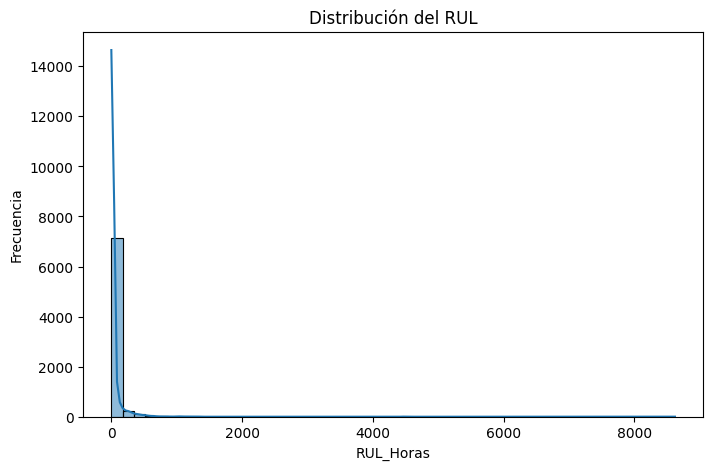

In [ ]:
# Distribución de RUL
print("\nDistribución de RUL:")
plt.figure(figsize=(8,5))
sns.histplot(data['RUL_Horas'], bins=50, kde=True)
plt.title("Distribución del RUL")
plt.xlabel("RUL_Horas")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
# Rango de fechas
if 'fecha_telemetria' in data.columns and 'fecha_inicio' in data.columns:
    print("\nRango de fechas (inicio y fin):")
    print("Fecha mínima:", data['fecha_telemetria'].min(), "| Fecha máxima:", data['fecha_inicio'].max())

# Paso 2: Limpieza inicial de datos

In [ ]:
# ======================
# 1. Eliminar valores imposibles
# ======================

# Definimos rangos razonables para ciertas variables
rango_temp = (-50, 150)  # temperaturas en °C
rango_presion = (0, 500) # presión en PSI o kPa (depende tu sensor)
rango_rul = (0, 5000)    # recorte opcional para evitar colas largas

In [10]:
data.shape

(7521, 58)

In [7]:
# Verificamos valores nulos por filas
data = data.sort_values(by=['Ambient_Temp_Ave'],ascending=False,na_position='first') # Ordena todas las filas descendente colocando primero los nulos

In [8]:
data.head() # Existen tres filas con valores nulos

,equipment,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,Boost_RB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
782,C328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-13 19:13:43,2020-01-05 11:02:53,18663,3472
2787,C302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-09 02:34:18,2020-08-28 05:14:44,38332,1203
7098,C320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-07 07:22:27,2020-07-31 13:44:04,31892,8622
3386,C323,31.0,43.0,15.0,60.0,1.0,256.0,247.0,2.0,70.0,...,20740.0,7840.0,19600.0,22968.0,2937.0,2986.0,2021-12-31 16:55:54,2022-01-01 00:13:42,39814,8
5286,C323,28.0,48.0,17.0,59.0,1.0,254.0,244.0,3.0,69.0,...,21430.0,7840.0,20800.0,22925.0,2972.0,2932.0,2021-12-30 07:06:44,2021-12-30 15:53:59,39794,8


In [9]:
# Eliminaremos las filas con valores nulos
data = data.drop(index = [782,2787,7098])

In [15]:
dt

,equipment,Ambient_Temp_Ave,Ambient_Temp_Max,Ambient_Temp_Min,Atmos_Pres_Ave,Blow_by_Press_Max,Boost_LB_Press_Max,Boost_RB_Press_Max,BRAKE_ENERGY,Brake_Oil_Temp_LF_Ave,...,Motor_Torque_A_at_Retard_Mode_Max,Motor_Torque_B_at_Retard_Mode_Ave,Motor_Torque_B_at_Retard_Mode_Max,Steering_Press_Max,Wheel_Motor_A_Speed_Max,Wheel_Motor_B_Speed_Max,fecha_telemetria,fecha_alerta,horometro,RUL_Horas
3527,C328,10.0,24.0,0.0,59.0,2.0,282.0,280.0,13.0,46.0,...,21290.0,7690.0,20990.0,21788.0,2745.0,2734.0,2021-09-20 03:04:50,2021-10-22 04:05:20,28942,769
5410,C328,19.0,38.0,8.0,61.0,2.0,280.0,280.0,6.0,57.0,...,21730.0,6650.0,20270.0,21030.0,3148.0,3125.0,2021-01-15 06:39:03,2021-07-20 07:02:15,25782,4465
782,C328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-13 19:13:43,2020-01-05 11:02:53,18663,3472


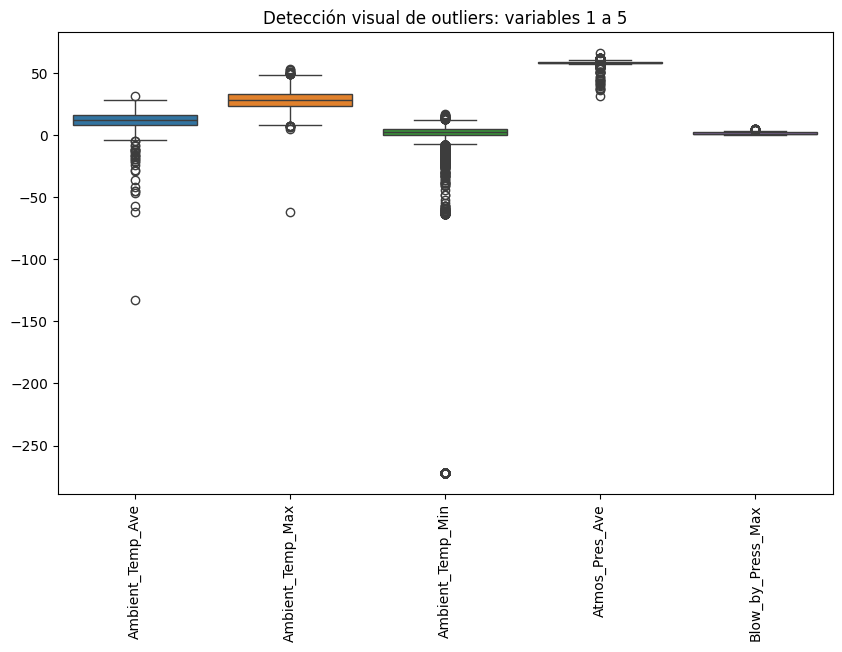

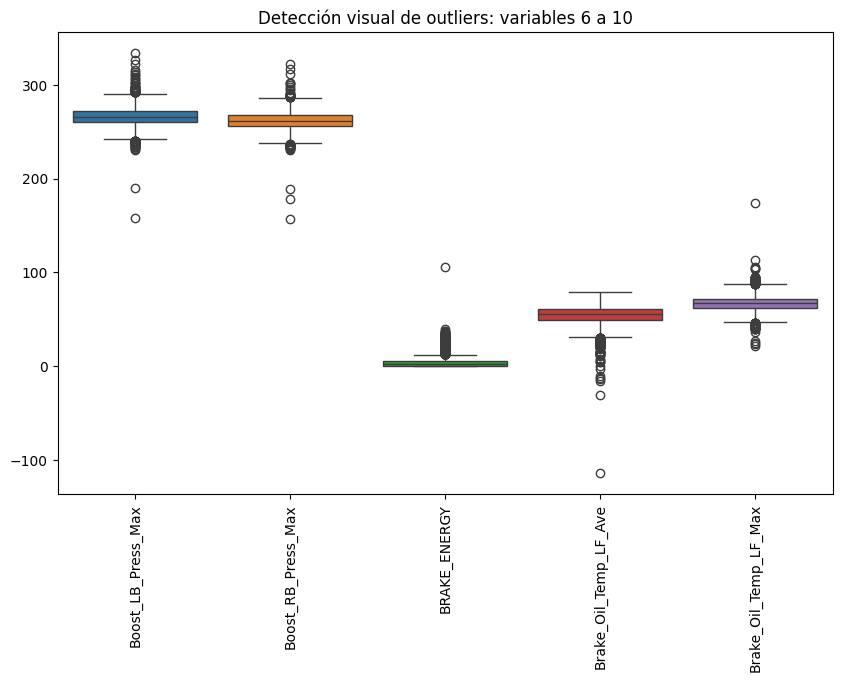

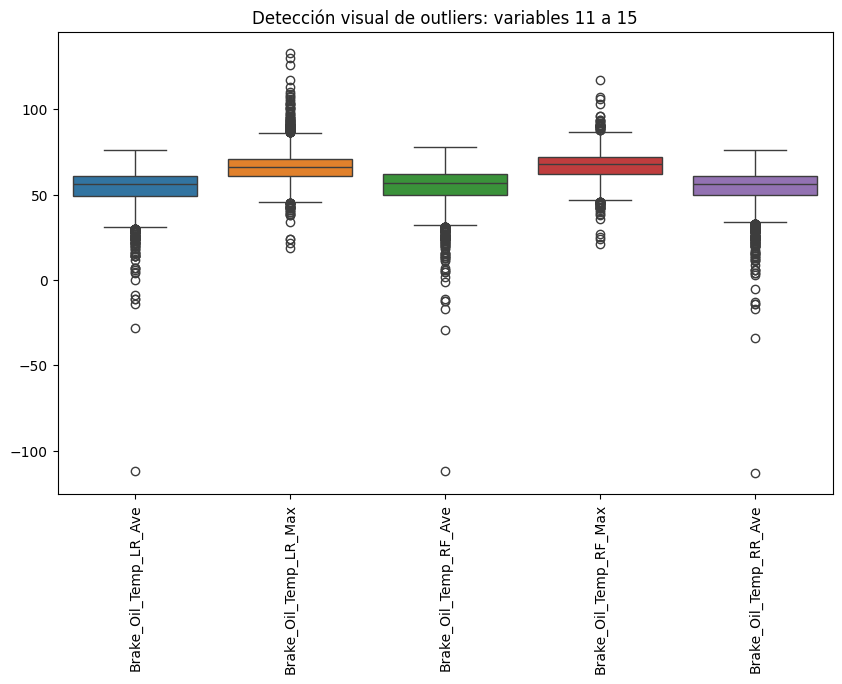

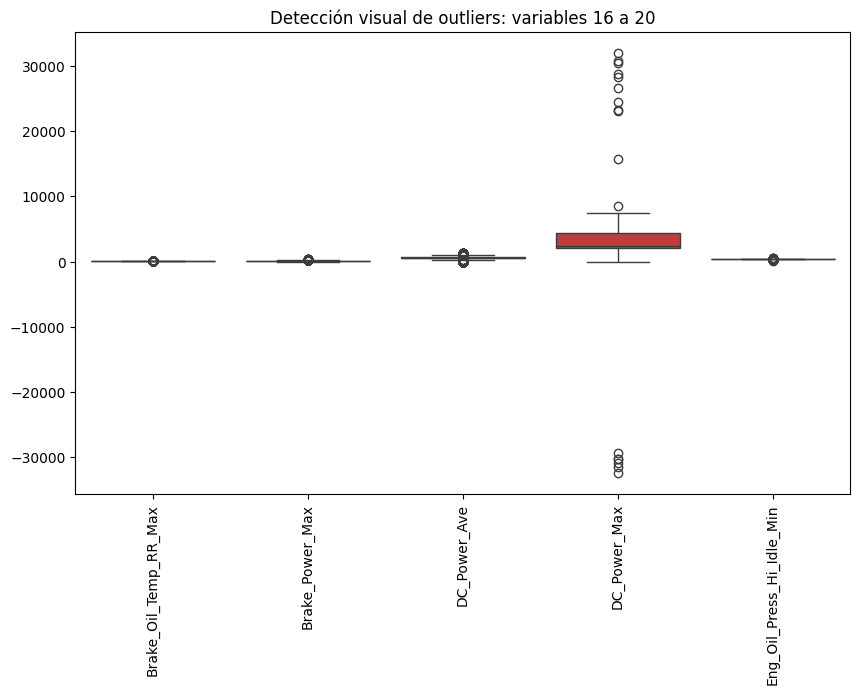

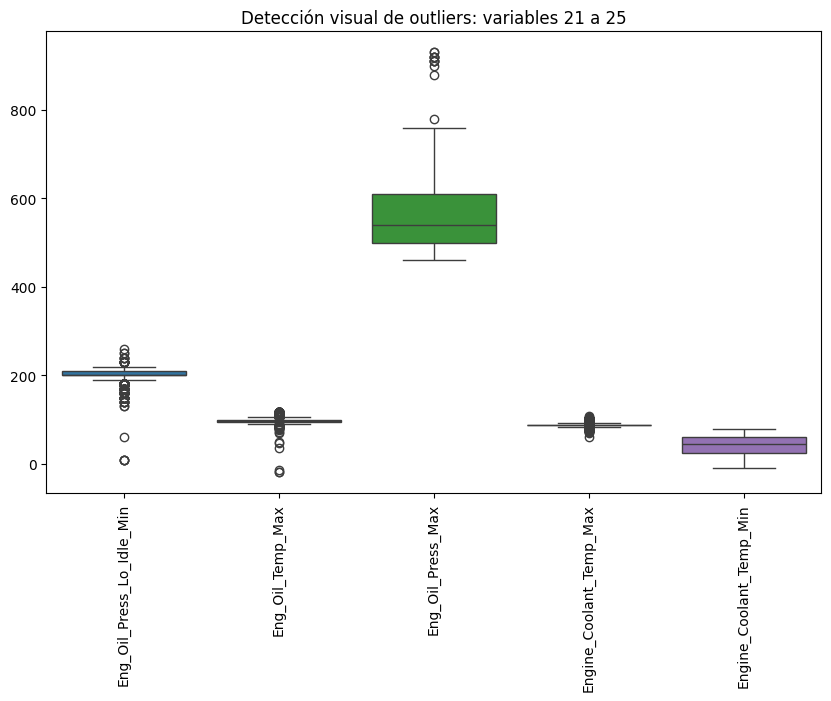

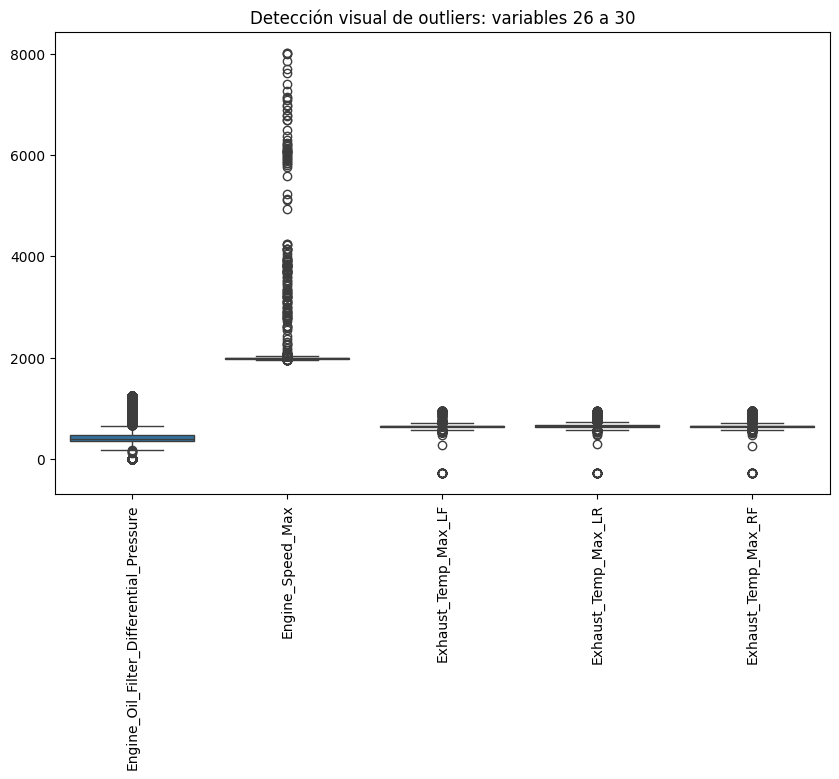

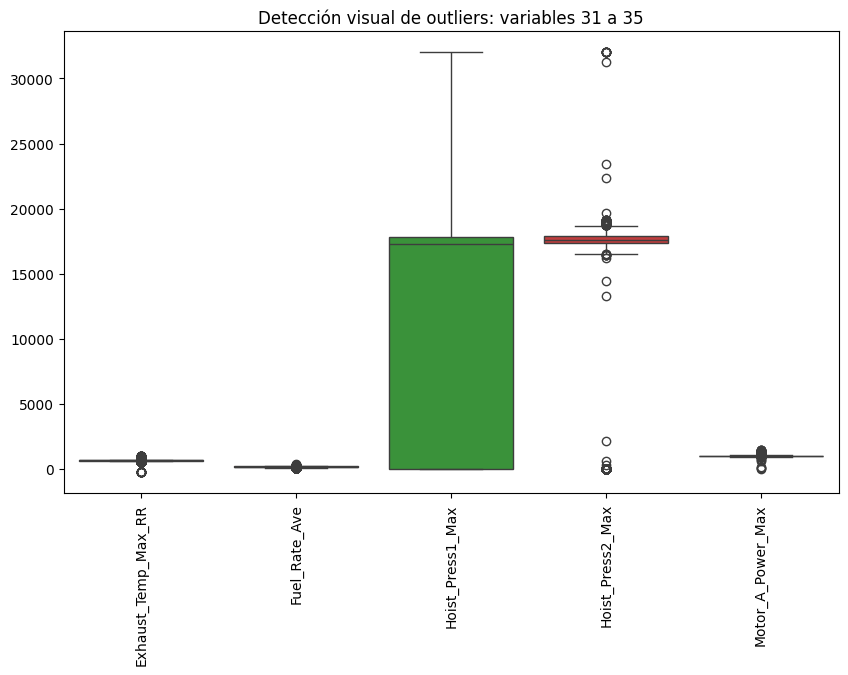

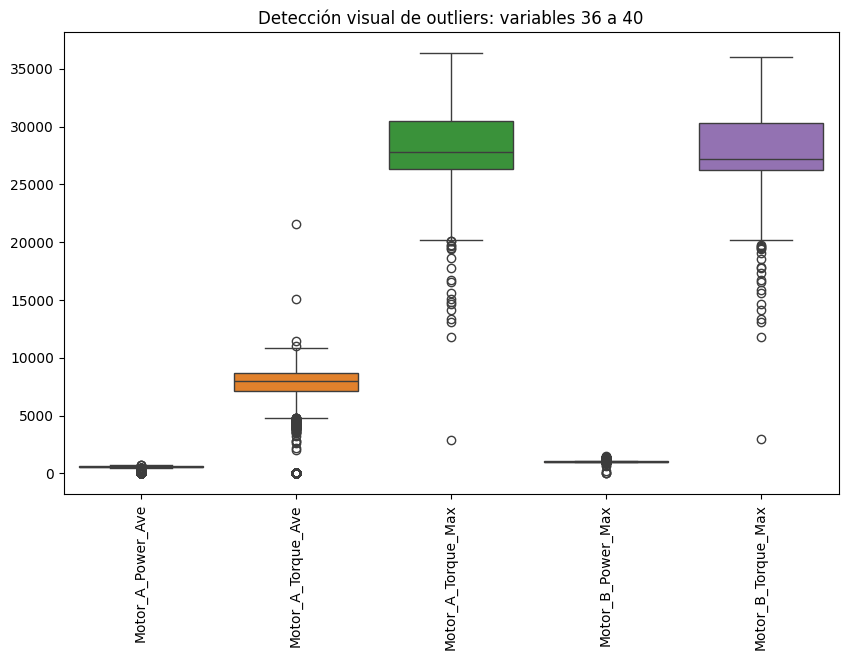

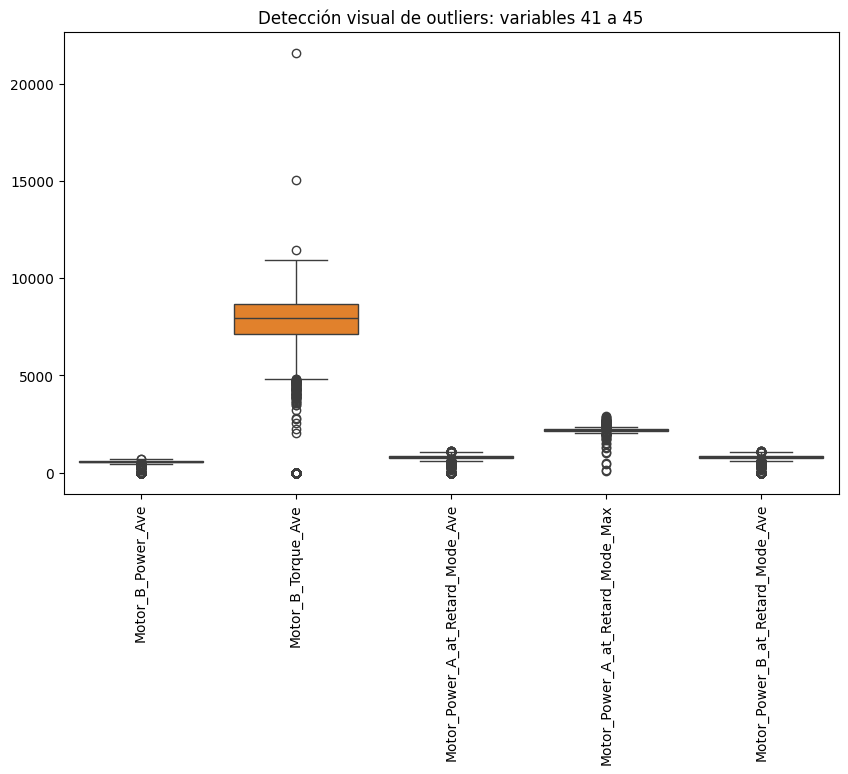

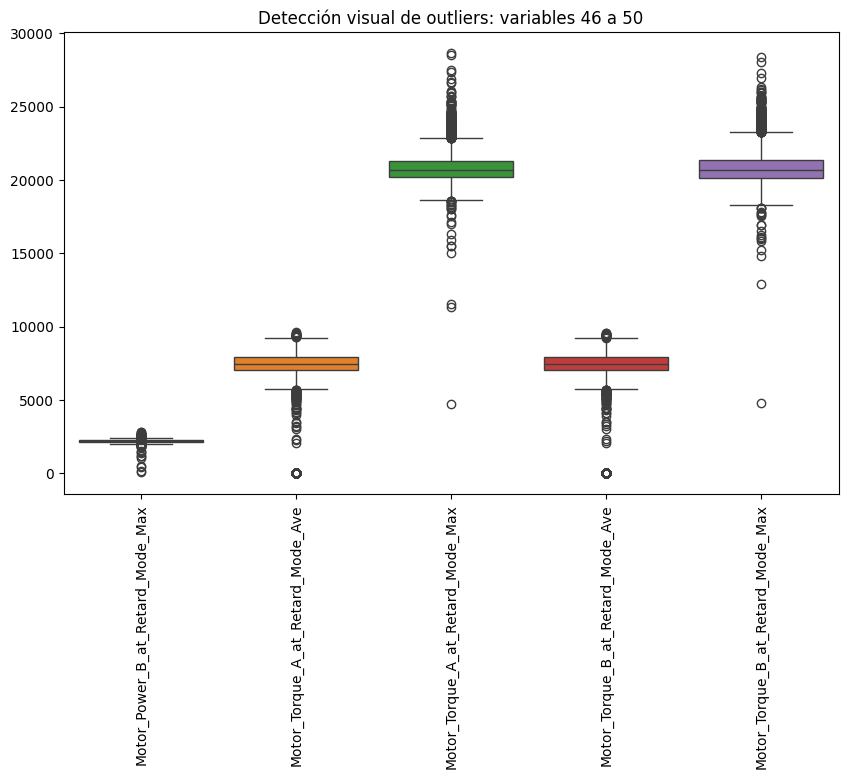

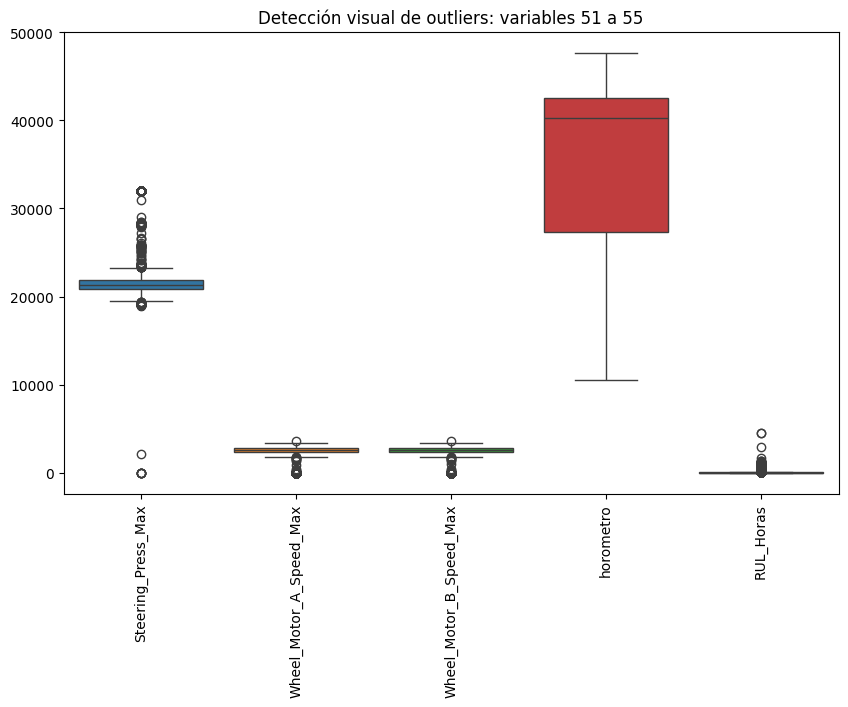

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filtrar columnas numéricas
numeric_data = data.select_dtypes(include=[np.number])

# Tamaño del lote (cantidad de variables por gráfico)
batch_size = 5

# Recorrer las columnas en lotes
for i in range(0, numeric_data.shape[1], batch_size):
    cols = numeric_data.columns[i:i+batch_size]

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=numeric_data[cols])
    plt.xticks(rotation=90)
    plt.title(f"Detección visual de outliers: variables {i+1} a {i+len(cols)}")
    plt.show()


In [ ]:
for col in cols_temp:
     data= (data[(data[col].isnull()) | ((data[col] >= rango_temp[0]) & (data[col] <= rango_temp[1]))])

In [ ]:
for col in cols_temp:
    data = data[(~data[col].isnull()) & ((data[col] < rango_temp[0]) | (data[col] > rango_temp[1]))]


In [ ]:
data.shape

(3, 58)

In [ ]:
# Filtrar presiones imposibles
cols_presion = [col for col in data.columns if "Press" in col or "Pres" in col]
for col in cols_presion:
    data = data[(data[col].isnull()) | ((data[col] >= rango_presion[0]) & (data[col] <= rango_presion[1]))]

In [ ]:
# Recorte opcional del RUL
data = data[data["RUL_Horas"] <= rango_rul[1]]

In [ ]:
# ======================
# 2. Tratamiento de valores nulos
# ======================

# Umbral para eliminar columnas con demasiados nulos (ej: >40%)
umbral_nulos = 0.4
cols_muchos_nulos = [col for col in data.columns if data[col].isnull().mean() > umbral_nulos]
data.drop(columns=cols_muchos_nulos, inplace=True)

In [ ]:
# Rellenar nulos restantes con la mediana por equipo
for col in data.columns:
    if data[col].isnull().sum() > 0 and data[col].dtype != 'object':
        data[col] = data.groupby("equipment")[col].transform(lambda x: x.fillna(x.median()))

In [ ]:
# ======================
# 3. Filtrar equipos con muy pocos registros
# ======================
min_registros = 30
equipos_validos = data["equipment"].value_counts()[data["equipment"].value_counts() >= min_registros].index
data = data[data["equipment"].isin(equipos_validos)]

In [ ]:
# ======================
# 4. Reiniciar índices
# ======================
data.reset_index(drop=True, inplace=True)

print(f"Datos limpios: {data.shape[0]} registros y {data.shape[1]} columnas")

Datos limpios: 0 registros y 5 columnas
